In [1]:
import numpy as np
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt

import multipletau

In [6]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
files = ["/mnt/sda1/Sophie/MouniaLagha/wetransfer_sna-suntag-fast-imaging_2022-10-04_1344/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t3_Airyscan Processing-20_spots.csv",
        "/mnt/sda1/Sophie/MouniaLagha/wetransfer_sna-suntag-fast-imaging_2022-10-04_1344/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t4_Airyscan Processing-20_spots.csv",
        "/mnt/sda1/Sophie/MouniaLagha/wetransfer_sna-suntag-fast-imaging_2022-10-04_1344/220822 scFv msGFP2 x Snail Core 32X Suntag 24X MS2 E1 z8 t5_Airyscan Processing-20_spots.csv"]

In [21]:
def func_(x, T, c):
    return (((T-x)/(c*T**2))*np.heaviside((T-x),0))

columns = ['file_name', 'track_id', 'elongation_time', 'translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]
for f in files:
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    


    for id_ in np.unique(datas['TRACK_ID']):
        mm = int(len(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values)/2-1)
        if (mm%2)==0: 
            autocor = multipletau.autocorrelate(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/65535*100,
                                            m=mm,
                                            normalize=False)
        else: 
            autocor = multipletau.autocorrelate(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/65535*100,
                                            m=mm+1,
                                            normalize=False)

        popt, pcov = optimize.curve_fit(func_, 
                                    autocor.flatten()[0::2],
                                    autocor.flatten()[1::2], 
                                    method='lm' )

        d = pd.DataFrame.from_dict({'file_name':f.split('/')[-1].split(' ')[-2],
                                    'track_id':id_,
                                    'elongation_time':popt[0],
                                    'translation_rate':popt[1]},
                                   orient='index').T
        result = pd.concat([result, d], ignore_index=True)


In [23]:
result['elongation_time_norm'] = result['elongation_time']/0.39
result['translation_rate_norm'] = result['translation_rate']/0.39

In [24]:
result

,file_name,track_id,elongation_time,translation_rate,elongation_time_norm,translation_rate_norm
0,t3_Airyscan,1,0.241823,0.093354,0.620058,0.239368
1,t3_Airyscan,2,0.13408,0.12528,0.343795,0.321231
2,t3_Airyscan,3,0.125469,0.076858,0.321716,0.197072
3,t3_Airyscan,10,0.192419,0.173349,0.493382,0.444485
4,t3_Airyscan,18,0.152005,0.101136,0.389757,0.259324
5,t3_Airyscan,22,0.253375,0.086874,0.649679,0.222754
6,t3_Airyscan,27,0.3014,0.068586,0.77282,0.17586
7,t3_Airyscan,34,0.239452,0.099172,0.61398,0.254286
8,t3_Airyscan,36,0.190284,0.151615,0.487908,0.388756
9,t3_Airyscan,39,0.234591,0.103101,0.601517,0.264361


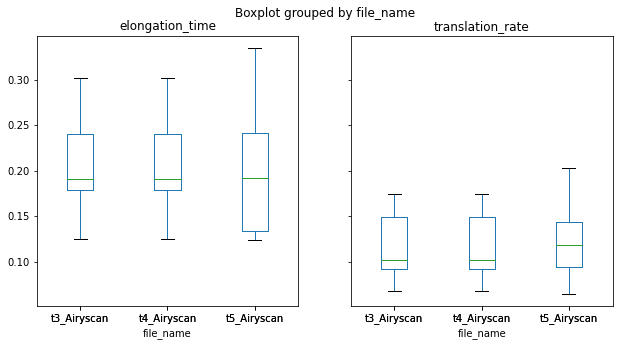

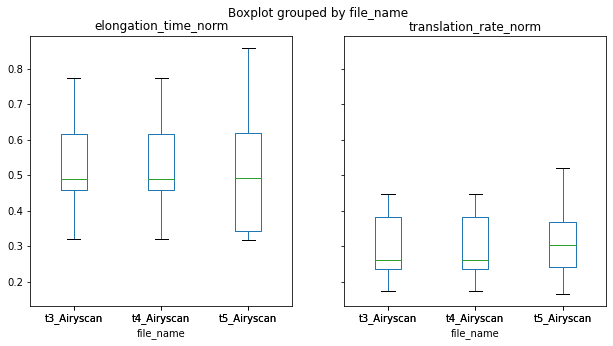

In [25]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = result.boxplot(['elongation_time', 'translation_rate'] , by='file_name', grid=False, figsize=(10,5))
fig, ax = result.boxplot(['elongation_time_norm', 'translation_rate_norm'] , by='file_name', grid=False, figsize=(10,5))


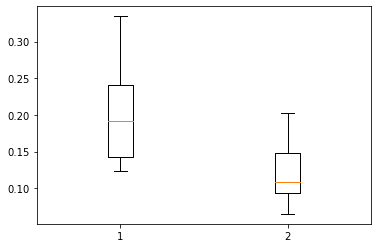

In [26]:
fig, ax = plt.subplots()
_ = ax.boxplot([result['elongation_time'], result['translation_rate']])

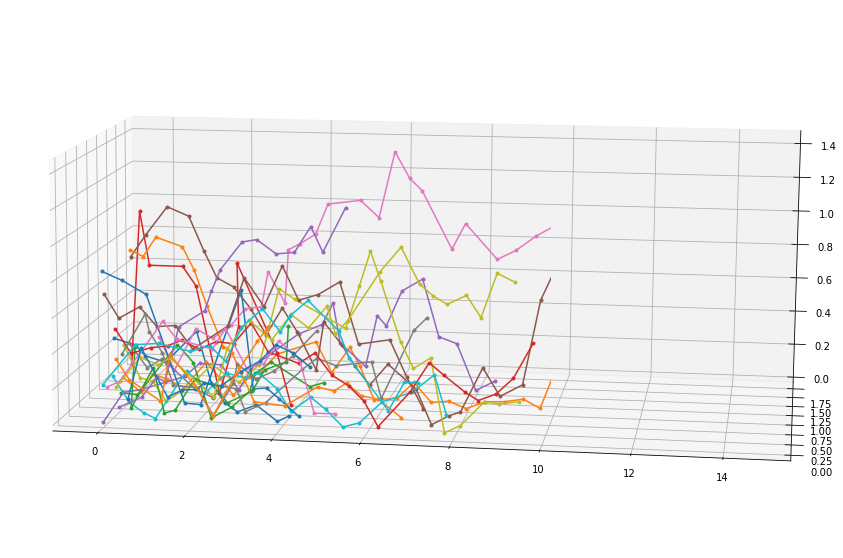

In [27]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2, 1, 1, 1]))

for id_ in np.unique(datas['TRACK_ID']):

    ax.plot(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()-np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()),
             datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()-np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()),
             datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()-np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()),
            '.-')



fig.set_size_inches((10,10))

ax.view_init(elev=10., azim=-80)

In [28]:
def func_(x, T, c):
    return (((T-x)/(c*T**2))*np.heaviside((T-x),0))

elongation_time=[]
translation_rate=[]

for id_ in np.unique(datas['TRACK_ID']):
    autocor = multipletau.autocorrelate(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/65535*100,
                                   m=int(len(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values)/2-1))

    popt, pcov = optimize.curve_fit(func_, 
                                autocor.flatten()[0::2],
                                autocor.flatten()[1::2], 
                                method='lm' )
    
    elongation_time.append(popt[0]/0.39*100)
    translation_rate.append(popt[1]/0.39*100)


/home/u2175049/anaconda3/lib/python3.9/site-packages/multipletau/core.py:187: InvalidMWarning: Invalid value of m=11. Using m=12 instead
  warnings.warn("Invalid value of m={}. Using m={} instead"
/home/u2175049/anaconda3/lib/python3.9/site-packages/multipletau/core.py:187: InvalidMWarning: Invalid value of m=7. Using m=8 instead
  warnings.warn("Invalid value of m={}. Using m={} instead"
/home/u2175049/anaconda3/lib/python3.9/site-packages/multipletau/core.py:187: InvalidMWarning: Invalid value of m=5. Using m=6 instead
  warnings.warn("Invalid value of m={}. Using m={} instead"


In [29]:
datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values

array([1065.        ,  966.23809524,  991.19047619, 1352.71428571,
       1449.0952381 , 1289.57142857, 1310.9047619 , 1479.80952381,
       1028.        , 1230.76190476])

In [30]:
np.unique(datas.TRACK_ID)

array([  1,   5,  19,  23,  35,  40,  43,  46,  54,  56, 108, 141, 142,
       143, 155, 162, 173, 194, 195, 213, 222, 236])

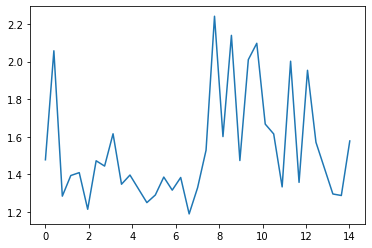

In [31]:
id_= 5
x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/65535*100
plt.plot(x,y)

[ 1.18550087 23.67729208]


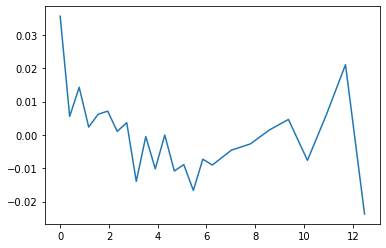

In [32]:
autocor = multipletau.autocorrelate(y, m=int(len(y)/2-1), normalize=True)
# autocor = multipletau.autocorrelate(y, m=2, normalize=True)
# autocor = multipletau.correlate(y,y, normalize=True)

popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )


plt.plot(autocor.flatten()[0::2]*0.39, autocor.flatten()[1::2])

# plt.plot(autocor.flatten()[0::2]*0.39, func_(autocor.flatten()[0::2], *popt) )
print(popt)

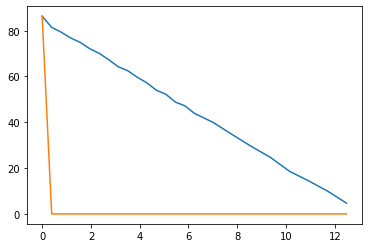

In [33]:
autocor = multipletau.autocorrelate(y)


popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )

plt.plot(autocor.flatten()[0::2]*0.39, autocor.flatten()[1::2])
plt.plot(autocor.flatten()[0::2]*0.39, func_(autocor.flatten()[0::2], *popt) )